# CAS KAGGLE: SUPER MARIO - APRENDIZAJE POR REFUERZO

El siguiente trabajo trata sobre el desarrollo de un agente inteligente para el famoso juego producido por Nintendo Super Mario Bros.


El entorno que usaré en este caso será extraido de kaggle:
    
ENTORNO: https://www.kaggle.com/datasets/alincijov/gym-super-mario-bros

# FUNDAMENTO TEÓRICO

En el aprendizaje por refuerzo, un agente interactúa con su entorno, realizando acciones y recibiendo recompensas por estas acciones. A través de este proceso de prueba y error, el agente adquiere información valiosa sobre su entorno y aprende a navegarlo de manera efectiva. Aquí están los componentes clave de este proceso:

•	El Agente: Este es el personaje que estamos entrenando para resolver un problema específico. Aprende de sus experiencias, tanto de sus errores como de sus éxitos. En este caso, nuestro agente es Mario.

•	El Ambiente: Este es el espacio en el que el agente interactuará y aprenderá. En nuestro caso, el am-biente es el nivel del juego en el que Mario se mueve.

•	Las Acciones: Estas son todas las posibles acciones que el agente puede realizar. Son los medios a través de los cuales el agente interactúa con su entorno. Para Mario, estas acciones podrían incluir moverse hacia adelante o hacia atrás, saltar, agacharse, etc.

•	Las Recompensas: Este es el núcleo del aprendizaje por refuerzo. Cada vez que el agente realiza una acción, recibe una recompensa que puede ser positiva, negativa o cero. Las recompensas indican al agente si ha elegido una buena o mala acción, permitiéndole aprender de sus acciones y trabajar hacia su objetivo. Las recompensas pueden variar desde ganar una vida, pasar el nivel, perder un poder, morir, o no recibir ninguna recompensa.

•	El Estado: Este es la nueva posición que el agente ocupa en el ambiente después de realizar una acción. Para Mario, cada nueva posición que ocupa en el nivel se convierte en un nuevo estado. El estado inicial es donde Mario comienza el nivel, y el estado final es cuando completa el nivel.

# IMPORTACIONES

Se importan varias bibliotecas necesarias para el funcionamiento del script. Esto incluye torch para el aprendizaje automático, gym para el entorno de aprendizaje por refuerzo, PIL y matplotlib para el procesamiento y visualización de imágenes, y varias otras para diversas funciones.

In [1]:
import torch
from torch import nn
from torchvision import transforms as T
import time, datetime
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, copy
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage
import gymnasium as gym
from gym import Wrapper
from gym.spaces import Box
from gym.wrappers import FrameStack, GrayScaleObservation, ResizeObservation


import os
os.chdir('C:/Users/1636620/OneDrive - UAB/Escritorio/PRACTICAS/APC/CAS_MARIO/archive')


from nes_py.wrappers import JoypadSpace

import gym_super_mario_bros
from gym_super_mario_bros.actions import RIGHT_ONLY

# CREACIÓN DEL ENTORNO

Se crea un entorno de juego de Super Mario Bros. Esto incluye la especificación de la versión del juego, el nivel y el modo de renderizado. Luego, el entorno se envuelve con JoypadSpace, que limita el conjunto de acciones posibles a las especificadas (RIGHT_ONLY).

In [2]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, RIGHT_ONLY)

C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


### AGENTE TONTÍSIMO - V1 (SÓLO DERECHA Y SALTAR ALEATORIAMENTE)

In [18]:
done = False
while not done:
    action = env.action_space.sample()
    _, _, done, _, _= env.step(action)
    env.render()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [8]:
env.reset()

(<gym.wrappers.frame_stack.LazyFrames at 0x17ed212c900>, {})

# PREPROCESADO DEL ENTORNO

Antes de introducirlo en una red neuronal, hay que construir un entorno y envolverlo con nuestras modificaciones para facilitar el aprendizaje del agente. Repasaré estas modificaciones línea por línea.

- gym_super_mario_bros.make: permite construir el entorno SuperMarioBros especificado y devuelve el respectivo env.
- CustomReward: modifica la recompensa devuelta customizada.
- JoypadSpace: Hay tres listas de acciones disponibles: RIGHT_ONLY, SIMPLE_MOVEMENT y COMPLEX_MOVEMENT, que aumentan el número de acciones posibles que puede realizar Mario, desde sólo poder correr hacia la derecha y saltar hasta desbloquear todo su conjunto de habilidades y movimientos. SIMPLE_MOVEMENT es un buen equilibrio entre ofrecer a Mario un abanico de movimientos y no saturar el espacio de acción con un gran número de acciones posibles, lo que dificultaría su aprendizaje.
- SkipFrame: Omite un cierto número de frames entre cada acción. En cada paso, repite la misma acción un número determinado de veces (4), suma las recompensas de cada paso y devuelve la observación, la recompensa total, si el episodio ha terminado, y la información adicional del último paso.
- GrayScaleObservation: Convierte todas las imágenes a una imagen en escala de grises de un solo canal.
- ResizeObservation: Redimensiona a una imagen cuadrada NxN según lo especificado (84x84). De este modo, la red encuentra más rápida y fácilmente las características clave de cada observación.
- FrameStack: Apila el número especificado de fotogramas en una secuencia para mostrar el movimiento de los objetos. La configuración predeterminada es apilar cuatro fotogramas juntos para iluminar las diferencias sutiles entre los fotogramas y permitir que la red descifre el movimiento.

In [2]:
class SkipFrame(Wrapper):
    
    def __init__(self, env, skip):
        """Devuelve solo cada 4º (skip) fotograma"""
        super().__init__(env)
        self._skip = skip
        self._actual_score = 0
        
    def step(self, action, custom_reward = True):
        """Repite y suma accion y recompensas"""
        total_reward = 0.0
        for i in range(self._skip):
            obs, reward, done, trunk, info = self.env.step(action)
            if(custom_reward):
                reward += (info['score'] - self._actual_score) / 40.0
                self._actual_score = info['score']
                if info['y_pos'] > 180:
                    reward += 10
                if done:
                    if info['flag_get']:
                        reward += 350.0
                        break
                    else:
                        reward -= 50.0
                        break
            if done:
                break
            total_reward += reward
        return obs, total_reward, done, trunk, info

In [3]:
def crea_entorno(framestack):
    env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', render_mode='human', apply_api_compatibility=True)
    #env = CustomReward(env)
    env = JoypadSpace(env, RIGHT_ONLY)
    env = SkipFrame(env, skip=4) # ACCION = 4 FRAMES
    env = ResizeObservation(env, shape=84) # RESIZE FRAME DE 240x256 A 84x84
    env = GrayScaleObservation(env)
    if framestack:
        env = FrameStack(env, num_stack=4, lz4_compress=True) 
    return env

LO QUE NOSOTROS VEMOS


C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] No se puede cambiar el modo de subproceso después de establecerlo
  warnings.warn(str(err))
C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


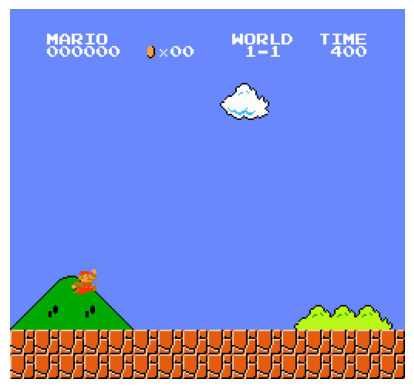

LO QUE VE NUESTRO MODELO


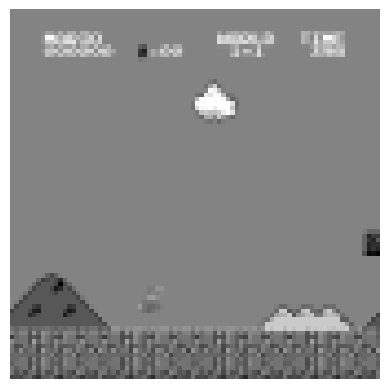

In [5]:
def MODELO_VS_VISTA(test_env):
    
  obs = test_env.reset()
  for i in range(10):
      action = test_env.action_space.sample()
      obs, reward, done, info, _= test_env.step(action)

  from matplotlib import pyplot as plt
  if obs.shape[0] == 4:
    plt.imshow(obs[-1], cmap='gray')
    plt.axis('off')
  else:
    plt.imshow(obs)
    plt.axis('off')
  plt.show()
  del test_env
    
    
print("LO QUE NOSOTROS VEMOS")
MODELO_VS_VISTA(gym_super_mario_bros.make('SuperMarioBros-1-1-v0', render_mode='human', apply_api_compatibility=True))
print("LO QUE VE NUESTRO MODELO")
MODELO_VS_VISTA(crea_entorno(True))

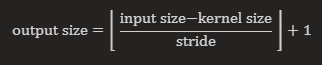

In [4]:
class AgentNN(nn.Module):
    """
    Red neuronal convolucional que se utiliza para aproximar la función Q.
    Estructura CNN:
    entrada -> (conv2d + ReLU) x 3 -> Flatten -> (capa densa totalmente conectada + ReLU) 
    -> capa densa totalmente conectada -> salida
    """
    def __init__(self, input_shape, n_actions, freeze=False):
        """
        Inicializa la red neuronal.
        :param input_shape: Tamaño de la entrada de la red neuronal.
        :param n_actions: Número de acciones que puede realizar el agente.
        :param freeze: Si es True, congela los pesos de la red neuronal.
        """
        super().__init__()
        
        channel, height, width = input_shape
        if height != 84 or width != 84:
          raise ValueError(f'Input height and width esperado: 84,actual:height {height}, width {width}')
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4), # (20 X 20 X 32)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),  # (8 X 8 X 64)
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1), # (7 X 7 X 64)
            nn.ReLU(),
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.network = nn.Sequential(
            self.conv_layers,
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
            # Esta capa no tiene ReLU  porque la salida de esta capa se utiliza
            # directamente como las puntuaciones de las acciones en la función Q
        )

        if freeze:
            self._freeze()
        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.to(self.device)

    def forward(self, x):
        """
        Propaga la entrada por la red neuronal.
        :param x: Entrada de la red neuronal.
        :return: Salida de la red neuronal.
        """
        return self.network(x)

    def _get_conv_out(self, shape):
        """
        Calcula el tamaño de la salida de las capas convolucionales.
        :param shape: Tamaño de la entrada de la red neuronal.
        :return: Tamaño de la salida de las capas convolucionales.
        """
        o = self.conv_layers(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def _freeze(self):
        """
        Congela los pesos de la red neuronal.
        """  
        for p in self.network.parameters():
            p.requires_grad = False
    

In [5]:
class Agent:
    """
    Agente que utiliza Deep Q-Learning para aprender a jugar al videojuego.
    """
    def __init__(self, 
                 input_dims, 
                 num_actions, 
                 lr=0.00025, 
                 gamma=0.9, 
                 epsilon=1.0, 
                 eps_decay=0.99999604821871, 
                 eps_min=0.1, 
                 replay_buffer_capacity=100000, 
                 batch_size=32, 
                 sync_network_rate=500,
                 use_DDQN = True):
        """
        Inicializa el agente.
        :param input_dims: Tamaño de la entrada de la red neuronal.
        :param num_actions: Número de acciones que puede realizar el agente.
        :param lr: Tasa de aprendizaje.
        :param gamma: Factor de descuento.
        :param epsilon: Probabilidad de realizar una acción aleatoria.
        :param eps_decay: Factor de decaimiento de epsilon.
        :param eps_min: Valor mínimo de epsilon.
        :param replay_buffer_capacity: Tamaño del buffer de memoria.
        :param batch_size: Tamaño del batch.
        :param sync_network_rate: Número de pasos que deben transcurrir para sincronizar las redes.
        :param use_DDQN: 
        """
        self.num_actions = num_actions
        self.learn_step_counter = 0


        self.lr = lr
        self.gamma = gamma
        self.epsilon_EXPLORATION = epsilon
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.batch_size = batch_size
        self.sync_network_rate = sync_network_rate
        self.use_DDQN = use_DDQN

        self.online_network = AgentNN(input_dims, num_actions)
        self.target_network = AgentNN(input_dims, num_actions, freeze=True)


        self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=self.lr)
        # self.loss = torch.nn.MSELoss() # Puedo probar tambien MSE
        self.loss = torch.nn.SmoothL1Loss() 

        # Replay buffer
        storage = LazyMemmapStorage(replay_buffer_capacity)
        self.replay_buffer = TensorDictReplayBuffer(storage=storage)

    def choose_action(self, observation):
        """
        Elige una acción.
        :param observation: Observación actual.
        :return: Acción elegida.
        """
        #EXPLORA
        if np.random.random() < self.epsilon_EXPLORATION:
            return np.random.randint(self.num_actions)

        observation = torch.tensor(np.array(observation), dtype=torch.float32) \
                        .unsqueeze(0) \
                        .to(self.online_network.device)

        return self.online_network(observation).argmax().item()
    
    def decay_epsilon(self):
        """
        Decae el valor de epsilon.
        """
        self.epsilon_EXPLORATION = max(self.epsilon_EXPLORATION * self.eps_decay, self.eps_min)

    def store_in_memory(self, state, action, reward, next_state, done):
        """
        Almacena una transición en el buffer de memoria.
        :param state: Estado actual.
        :param action: Acción realizada.
        :param reward: Recompensa recibida.
        :param next_state: Siguiente estado.
        :param done: Si el episodio ha terminado.
        """
        self.replay_buffer.add(TensorDict({
                                            "state": torch.tensor(np.array(state), dtype=torch.float32), 
                                            "action": torch.tensor(action),
                                            "reward": torch.tensor(reward), 
                                            "next_state": torch.tensor(np.array(next_state), dtype=torch.float32), 
                                            "done": torch.tensor(done)
                                          }, batch_size=[]))
        
    def sync_networks(self):
        if self.learn_step_counter % self.sync_network_rate == 0 and self.learn_step_counter > 0:
            self.target_network.load_state_dict(self.online_network.state_dict())

    def save_model(self, path):
        """
        Carga los pesos de la red neuronal.
        :param path: Ruta del archivo que contiene los pesos de la red neuronal.
        """
        torch.save(self.online_network.state_dict(), path)

    def load_model(self, path):
        self.online_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(torch.load(path))

    def learn(self):
        """
        Aprende a jugar al videojuego.
        """
        # Si el tamaño del buffer es menor que el tamaño del lote, no aprendemos nada
        if len(self.replay_buffer) < self.batch_size:
            return
        
        # Sincroniza las redes online y objetivo
        self.sync_networks()
        # Reinicia los gradientes de la red
        self.optimizer.zero_grad()
        # Muestra un lote de transiciones del buffer de repetición y lo mueve al dispositivo correcto
        samples = self.replay_buffer.sample(self.batch_size).to(self.online_network.device)
        # Define las claves para extraer del lote de muestras
        keys = ("state", "action", "reward", "next_state", "done")
        # Extrae los estados, acciones, recompensas, estados siguientes y done del lote de muestras
        states, actions, rewards, next_states, dones = [samples[key] for key in keys]
        
        # Predice los valores Q para los estados usando la red en línea
        predicted_q_values = self.online_network(states) 
        # Selecciona los valores Q para las acciones tomadas
        predicted_q_values = predicted_q_values[np.arange(self.batch_size), actions.squeeze()]

        if self.use_DDQN:
            # DDQN: Usa la red en línea para seleccionar la próxima acción
            online_next_state_actions = self.online_network(next_states).argmax(dim=1)
            # DDQN: Usa la red objetivo para calcular el Q-value de la próxima acción y la acción seleccionada
            target_q_values = self.target_network(next_states).gather(1, online_next_state_actions.unsqueeze(-1)).squeeze(-1)
        else:
            # DQN: Usa la red objetivo para seleccionar la próxima acción y calcular su Q-value
            target_q_values = self.target_network(next_states).max(dim=1)[0]
            
         # Calcula los valores Q objetivo, teniendo en cuenta si el estado es terminal o no
        target_q_values = rewards + self.gamma * target_q_values * (1 - dones.float())
        
        # Calcula la pérdida entre los valores Q predichos y objetivo
        loss = self.loss(predicted_q_values, target_q_values)
        # Propaga la pérdida hacia atrás a través de la red
        loss.backward()
        # Actualiza los pesos de la red
        self.optimizer.step()
        
        
        # Incrementa el contador de pasos de aprendizaje
        self.learn_step_counter += 1
        # Decae la tasa de exploración
        self.decay_epsilon()

In [6]:
def train_and_collect_rewards(env, agent, num_episodes, ENTRENAMIENTO, use_DDQN, INTERVALO_GUARDADO):
    rewards = []
    sum_reward = 0
    if not ENTRENAMIENTO:
        folder_name = "models"
        ckpt_name = "DDQN_model_2000_iter.pt"
        agent.load_model(os.path.join(folder_name, ckpt_name))
        agent.epsilon_EXPLORATION = 0.2
        agent.eps_min = 0.0
        agent.eps_decay = 0.0

    env.reset()
    next_state, reward, done, trunc, info = env.step(action=0)

    for i in range(num_episodes):    
        done = False
        state, _ = env.reset()
        total_reward = 0
        while not done:
            a = agent.choose_action(state)
            new_state, reward, done, truncated, info  = env.step(a)
            total_reward += reward

            if ENTRENAMIENTO:
                agent.store_in_memory(state, a, reward, new_state, done)
                agent.learn()

            state = new_state

        #sum_reward += total_reward
        #average_reward = sum_reward / i if i > 0 else 0
        rewards.append(total_reward)

        print("Episodio: {}\nRecompensa: {}\nEpsilon: {:.2f}\nTamaño buffer: {}\nLearn step count: {}\n---".format(
    i, total_reward, agent.epsilon_EXPLORATION, len(agent.replay_buffer), agent.learn_step_counter))
        if ENTRENAMIENTO and (i + 1) % INTERVALO_GUARDADO == 0:
            model_name = "model_" + str(i + 1) + "_iter.pt"
            if use_DDQN:
                model_name = "DDQN_" + model_name
            else:
                model_name = "DQN_" + model_name
            agent.save_model(os.path.join(model_path, model_name))

    env.reset()
    return rewards

In [ ]:
ENTRENAMIENTO = True
INTERVALO_GUARDADO = 500 
NUM_EPISODIOS = 2000 
framestack = True

rewards_dqn = []
rewards_ddqn = []

env = crea_entorno(framestack)

#use_DDQN=False
#agent_dqn = Agent(input_dims=env.observation_space.shape, num_actions=env.action_space.n, use_DDQN=use_DDQN)
use_DDQN=True
agent_ddqn = Agent(input_dims=env.observation_space.shape, num_actions=env.action_space.n, use_DDQN=use_DDQN)
#use_DDQN=False
#rewards_dqn = train_and_collect_rewards(env, agent_dqn, NUM_EPISODIOS, ENTRENAMIENTO, use_DDQN, INTERVALO_GUARDADO)
#use_DDQN=True
rewards_ddqn = train_and_collect_rewards(env, agent_ddqn, NUM_EPISODIOS, ENTRENAMIENTO, use_DDQN, INTERVALO_GUARDADO)
env.close()

C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] No se puede cambiar el modo de subproceso después de establecerlo
  warnings.warn(str(err))
C:\Users\1636620\OneDrive\ANACONDA\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodio: 0
Recompensa: 856.5
Epsilon: 1.00
Tamaño buffer: 184
Learn step count: 153
---
Episodio: 1
Recompensa: 933.5
Epsilon: 0.99
Tamaño buffer: 1660
Learn step count: 1629
---
Episodio: 2
Recompensa: 1217.5
Epsilon: 0.99
Tamaño buffer: 2794
Learn step count: 2763
---
Episodio: 3
Recompensa: 686.0
Epsilon: 0.99
Tamaño buffer: 3579
Learn step count: 3548
---
Episodio: 4
Recompensa: 622.5
Epsilon: 0.99
Tamaño buffer: 3749
Learn step count: 3718
---
Episodio: 5
Recompensa: 579.0
Epsilon: 0.98
Tamaño buffer: 3932
Learn step count: 3901
---
Episodio: 6
Recompensa: 676.0
Epsilon: 0.98
Tamaño buffer: 4023
Learn step count: 3992
---
Episodio: 7
Recompensa: 759.0
Epsilon: 0.98
Tamaño buffer: 4510
Learn step count: 4479
---
Episodio: 8
Recompensa: 648.5
Epsilon: 0.98
Tamaño buffer: 4666
Learn step count: 4635
---
Episodio: 9
Recompensa: 1015.5
Epsilon: 0.98
Tamaño buffer: 5090
Learn step count: 5059
---
Episodio: 10
Recompensa: 628.5
Epsilon: 0.98
Tamaño buffer: 5168
Learn step count: 5137
--

# ANÁLISIS Y MUESTRA DE RESULTADOS

# DQN VS DDQN

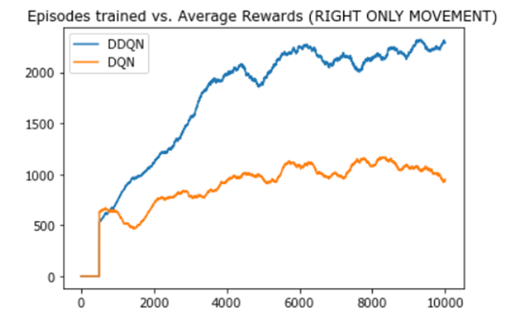

En un primer momento, al iniciar esta pràctica, he querido comparar el rendimiento de los dos algoritmos DQN y DDQN, pero al hacer unas cuantas búsquedas online me ha quedado claro que el DDQN funciona mucho mejor. Por tanto, usaré este algoritmo para mis experimentos. 

# DDQN - 2000 EP - STEP REWARDS

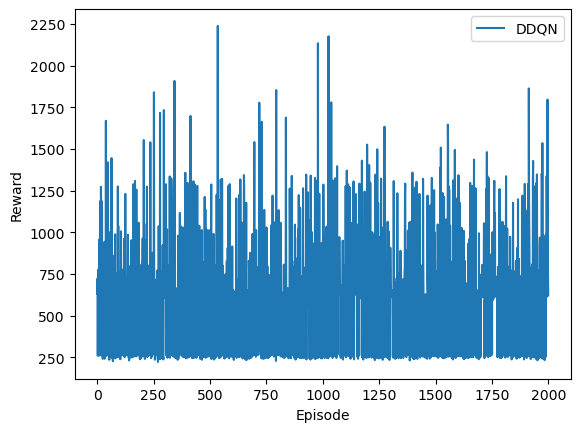

In [8]:
plt.plot(rewards_ddqn, label='DDQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

# DDQN - 2000 EP - CUSTOM REWARDS

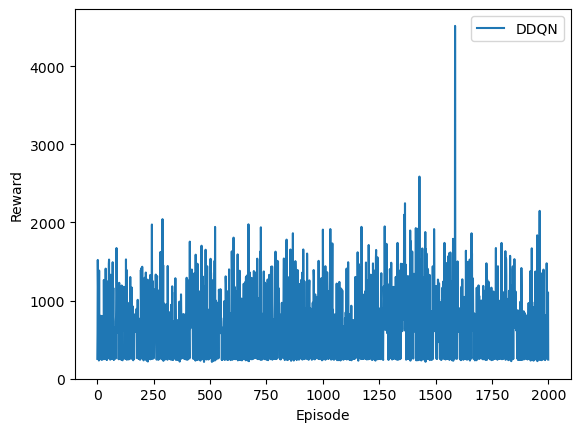

In [8]:
plt.plot(rewards_ddqn, label='DDQN')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.show()

Estos dos entrenamientos han durado aproximadamente 12h cada uno y me ha servido para sacar unas ciertas conclusiones acerca de mi agente:

- 2000 episodios de entrenamiento no son suficientes para entrenar un buen agente. Según las referencias, son nece-sarios entre 10.000 y 30.000 episodios para que el agente empiece a ganar partidas con frecuencia.

- Las recompensas custom han tenido un efecto positivo en el desempeño del agente. Se puede observar de forma clara que el DDQN con recompensa custom ha logrado pasarse el nivel 1 vez en el episodio 1600 aprox. Además, se registra una ligera evolución positva en las recompensas del agente, cosa que en la primera gráfica no se percibe.

- El valor de épsilon decay escogido durante el entrenamiento es erróneo. Me he dado cuenta tarde de que al final de los episodios el epsilon seguía siendo 0.89, cuando debería bajar hasta aproximadamente 0.1. Esto lo que hace es que el agente está tomando demasiadas acciones random incluso cuando se acerca el final del entrenamiento, y esto no debería ser así. 


In [16]:
eps_decay = (0.1 / 1.0) ** (1 / 2000)
print(eps_decay)

0.9988493699365052


In [24]:
import math

epsilon_initial = 1.0
epsilon_final = 0.89
eps_decay = 0.9999998

total_steps = math.log(epsilon_final / epsilon_initial) / math.log(eps_decay)
print(total_steps)

582669.0229960924


In [25]:
epsilon_final_new = 0.1

eps_decay_new = (epsilon_final_new / epsilon_initial) ** (1.0 / total_steps)
print(eps_decay_new)

0.99999604821871


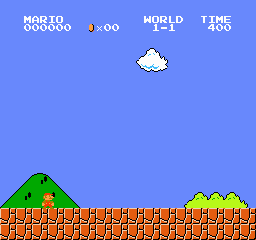

In [4]:
from IPython.display import Image

Image(filename="C:/Users/1636620/OneDrive - UAB/Escritorio/PRACTICAS/APC/CAS_MARIO/MARIO.gif")
